In [1]:
import pyart 
import numpy as np
import pandas as pd
import warnings
from siphon.simplewebservice.iastate import IAStateUpperAir
warnings.filterwarnings(action='ignore',category=DeprecationWarning)
warnings.filterwarnings(action='ignore',category=RuntimeWarning)
from datetime import datetime
import glob, os
import auto_filter,snr_noise,attenuation,calc_kdp,tools,retrieval


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
# Setting relevant paths
#-------------------------------------------------------------------------------------------------
input_volpath = '/scra6/ft21894/radartrunk/0603/0700-0800/'#KMPX/0500-0700/'
input_volpath2 = '/scra6/ft21894/radartrunk/0603/0700-0800/'#KARX/'
radarvollist = sorted(glob.glob(input_volpath+'KUEX20150603*'))
radarvollist2 = sorted(glob.glob(input_volpath2+'KOAX20150603*'))

In [3]:
print(len(radarvollist),len(radarvollist2))

12 12


In [4]:
# Read in radar files and save data time
#-------------------------------------------------------------------------------------------------
base = pyart.io.read_nexrad_archive(radarvollist[-1])
base2 = pyart.io.read_nexrad_archive(radarvollist2[-1])
base.fields.keys()
dt = datetime.strptime(base.time['units'][-20:], '%Y-%m-%dT%H:%M:%SZ')

# Read in sounding and interpolate onto radar gates
#-------------------------------------------------------------------------------------------------
date_name = datetime(2015,6,5,0)
station_name = 'KTOP'
df0620 = IAStateUpperAir.request_data(date_name,station_name)
T0620,z0620 = tools.interpolate_sounding_to_radar(df0620.dropna(),base)
T0620b,z0620b = tools.interpolate_sounding_to_radar(df0620.dropna(),base2)
base = tools.add_field_to_radar_object(T0620,base,'temp_radiosonde','degree','Temperature','Temperature','reflectivity')
base2 = tools.add_field_to_radar_object(T0620b,base2,'temp_radiosonde','degree','Temperature','Temperature','reflectivity')
base = tools.add_field_to_radar_object(z0620,base,'z_radiosonde','m',
                                       'gate_alt','gate_alt','reflectivity')
base2 = tools.add_field_to_radar_object(z0620b,base2,'z_radiosonde','m','gate_alt','gate_alt','reflectivity')

In [5]:
# Retrieve SNR and filter noise
#-------------------------------------------------------------------------------------------------
snr = pyart.retrieve.calculate_snr_from_reflectivity(base,'reflectivity','SNR')
snr2 = pyart.retrieve.calculate_snr_from_reflectivity(base2,'reflectivity','SNR')
base = tools.add_field_to_radar_object(snr['data'], base, 'SNR','','SNR','SNR','reflectivity')
base2 = tools.add_field_to_radar_object(snr2['data'], base2, 'SNR','','SNR','SNR','reflectivity')

zdr_corr = snr_noise.correct_zdr(base, zdr_name="differential_reflectivity", snr_name="SNR")
zdr_corr2 = snr_noise.correct_zdr(base2, zdr_name="differential_reflectivity", snr_name="SNR")
base = tools.add_field_to_radar_object(zdr_corr,base,'zdr_corr','dB','ZDR_nonoise','ZDR_nonoise','reflectivity')
base2 = tools.add_field_to_radar_object(zdr_corr2,base2,'zdr_corr','dB', 'ZDR_nonoise','ZDR_nonoise','reflectivity')

# Simple Gatefilter
#-------------------------------------------------------------------------------------------------
gatefilter = pyart.filters.GateFilter(base)
gatefilter.exclude_below('cross_correlation_ratio',0.7)
gatefilter2=pyart.filters.GateFilter(base2)
gatefilter2.exclude_below('cross_correlation_ratio', 0.7)

In [6]:
# Unfold phidp and calculate Kdp with csu_radartools
#-------------------------------------------------------------------------------------------------
unfphidic = pyart.correct.dealias_unwrap_phase(base,skip_checks=True,vel_field='differential_phase',nyquist_vel=90)
unfphidic2 = pyart.correct.dealias_unwrap_phase(base2,skip_checks=True,vel_field='differential_phase',nyquist_vel=90)

#recalculate phidp
base,kdp,fdp,sdp = calc_kdp.kdp_bringi(base,gatefilter,raw_phidp_name="differential_phase",refl_name="reflectivity")
base2,kdp2,fdp2,sdp2 = calc_kdp.kdp_bringi(base2,gatefilter2,raw_phidp_name="differential_phase",refl_name="reflectivity")

In [7]:
# Create Fake NCP Field
#-------------------------------------------------------------------------------------------------
try:
    base.fields['NCP']
    base2.fields['NCP']
except KeyError:
    ncp = pyart.config.get_metadata('normalized_coherent_power')
    ncp['data'] = np.ones_like(base.fields['reflectivity']['data'])
    ncp['description'] = "THIS FIELD IS FAKE. SHOULD BE REMOVED!"
    ncp2 = pyart.config.get_metadata('normalized_coherent_power')
    ncp2['data'] = np.ones_like(base2.fields['reflectivity']['data'])
    base.add_field('NCP', ncp)
    base2.add_field('NCP',ncp2)
    
# Correct reflectivity and Zdr attenuation
#-------------------------------------------------------------------------------------------------
#ZDR attenuation correction
base = attenuation.correct_attenuation_zdr(base,gatefilter=gatefilter,zdr_name='zdr_corr',phidp_name='KDP',alpha=0.016)
base2 = attenuation.correct_attenuation_zdr(base2,gatefilter=gatefilter2,zdr_name='zdr_corr',phidp_name='KDP',alpha=0.016)

In [8]:
import retrieval,echo_classification
warnings.filterwarnings(action='ignore',category=RuntimeWarning)

# Retrieve DSD, rainrate
#-------------------------------------------------------------------------------------------------
base = retrieval.retrieve_dsd(base,gatefilter=gatefilter,kdp_field='KDP',
                              zdr_field='zdr_acorr',refl_field='reflectivity')
base2 = retrieval.retrieve_dsd(base2,gatefilter=gatefilter2,kdp_field='KDP',\
                               zdr_field='zdr_acorr',refl_field='reflectivity')
base = retrieval.retrieve_rainrate(base,gatefilter=gatefilter,kdp_field='KDP',zdr_field='zdr_acorr',\
                                   refl_field='reflectivity',hid_field=None,method='CSU_KDP')
base2 = retrieval.retrieve_rainrate(base2,gatefilter=gatefilter2,kdp_field='KDP',zdr_field='zdr_acorr',\
                                    refl_field='reflectivity',hid_field=None,method='CSU_KDP')

# Retrieve Ice/Liquid Mass
#-------------------------------------------------------------------------------------------------
from csu_radartools import csu_liquid_ice_mass
dz = tools.extract_unmasked_data(base,'reflectivity')
dr = tools.extract_unmasked_data(base,'zdr_acorr')
dz2 = tools.extract_unmasked_data(base2,'reflectivity')
dr2 = tools.extract_unmasked_data(base2,'zdr_acorr')
mw, mi = csu_liquid_ice_mass.calc_liquid_ice_mass(dz,dr,z0620/1000.0,T=T0620)
mw2, mi2 = csu_liquid_ice_mass.calc_liquid_ice_mass(dz2,dr2,z0620b/1000.0,T=T0620b)

base = tools.add_field_to_radar_object(mw,base,'MW','g m-3',\
                                       'Liquid Water Mass','Liquid Water Mass','reflectivity')
base = tools.add_field_to_radar_object(mi,base,'MI','g m-3',\
                                       'Ice Water Mass','Ice Water Mass','reflectivity')
base2 = tools.add_field_to_radar_object(mw2,base2,'MW','g m-3','Liquid Water Mass','Liquid Water Mass','reflectivity')
base2 = tools.add_field_to_radar_object(mi2,base2,'MI','g m-3','Ice Water Mass','Ice Water Mass','reflectivity')

In [10]:
def calc_Dm_ice(zdp=False,kdp=False,wavelength=10):
    return -0.1+2*(zdp/(kdp*wavelength*10))**(0.5)

from copy import deepcopy
zdp = deepcopy(base.fields['ZDP']['data'][:])
kdp = deepcopy(base.fields['KDP']['data'][:])
refl= deepcopy(base.fields['reflectivity']['data'][:])
zdr = deepcopy(base.fields['zdr_acorr']['data'][:])
temp = deepcopy(base.fields['temp_radiosonde']['data'][:])
masked_zdp = np.ma.masked_where(np.logical_or(np.logical_or(np.logical_or(refl<0,zdr<0.1),kdp<0.01),temp>0),zdp)
masked_kdp = np.ma.masked_where(np.logical_or(np.logical_or(np.logical_or(refl<0,zdr<0.1),kdp<0.01),temp>0),kdp)
dm_ice = calc_Dm_ice(zdp=masked_zdp,kdp=masked_kdp,wavelength=10)

In [10]:
import importlib
importlib.reload(retrieval)
#import retrieval
base = retrieval.retrieve_icedsd_ryzhkov18(base,gatefilter,zdp_field='ZDP',kdp_field='KDP',zdr_field='zdr_acorr',
                          refl_field='reflectivity',temp_field='temp_radiosonde',band='S')

In [16]:
dm_ice = calc_Dm_ice(zdp=masked_zdp,kdp=masked_kdp,wavelength=10)
base= tools.add_field_to_radar_object(dm_ice,base,'Dm_ice','mm',\
                                       'Ice mean diameter','Ice mean diameter','reflectivity')

In [11]:
def calc_Ntice(zdp=False,kdp=False,refl=False,wavelength=10):
    return 0.1*refl-2*np.log10(zdp/(kdp*wavelength*10))-1.11
masked_refl = np.ma.masked_where(np.logical_or(np.logical_or(np.logical_or(refl<0,zdr<0.1),kdp<0.01),temp>0),refl)
Nt_ice = calc_Ntice(zdp=masked_zdp,kdp=masked_kdp,refl=masked_refl,wavelength=10)
base= tools.add_field_to_radar_object(Nt_ice,base,'Nt_ice','L-1',\
                                       'Total Ice Concentration','Total Ice Concentration','reflectivity')

In [11]:
gatefilter.exclude_above('zdr_acorr',6)

In [45]:
# Filter insect and ground clutter with csu_radartools and wradlib
#-------------------------------------------------------------------------------------------------
base, gf_noinsect, gf_gclutter = auto_filter.insect_clutter_filter(base,refl_field="reflectivity",
                                                                   zdr_field="zdr_corr")
base2, gf_noinsect2, gf_gclutter2 = auto_filter.insect_clutter_filter(base2,refl_field="reflectivity",
                                                                      zdr_field="zdr_corr")

KeyboardInterrupt: 

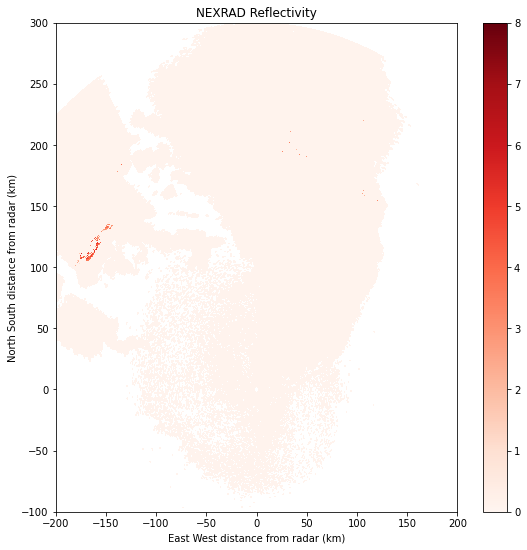

In [12]:
import matplotlib.pyplot as plt
display = pyart.graph.RadarDisplay(base)
fig = plt.figure(figsize=(9, 9))

# plot super resolution reflectivity
ax = fig.add_subplot(111)
display.plot('Nt_ice', 0, title='NEXRAD Reflectivity',vmin=0,vmax=8,cmap='Reds',
              colorbar_label='', ax=ax,gatefilter=gatefilter)
display.plot_range_ring(base.range['data'][-1]/1000., ax=ax)
display.set_limits(xlim=(-200, 200), ylim=(-100, 300), ax=ax) #-200,150; -150,200
plt.show()

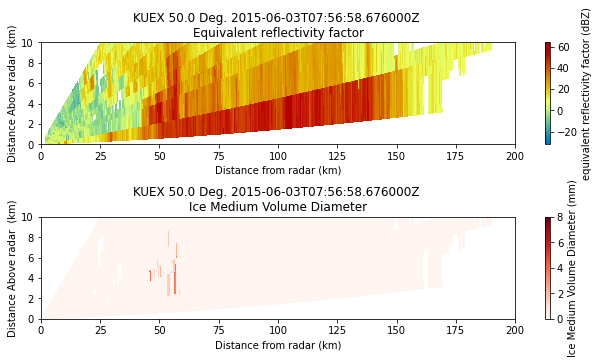

In [13]:
xsect = pyart.util.cross_section_ppi(base, [50])

display = pyart.graph.RadarDisplay(xsect)
f,axs = plt.subplots(2,1,figsize=(9,5))
display.plot('reflectivity', 0, vmin=-32, vmax=64,ax=axs[0])
display.set_limits(xlim=(0, 200), ylim=(0,10), ax=axs[0])
display.plot('Dm_ice', 0, vmin=0, vmax=8,cmap='Reds',ax=axs[1])
display.set_limits(xlim=(0, 200), ylim=(0,10), ax=axs[1])
plt.tight_layout()
plt.show()

In [ ]:
tools.add_field_to_radar_object(mw,base,'MW','g m-3',\
                                       'Liquid Water Mass','Liquid Water Mass','reflectivity')

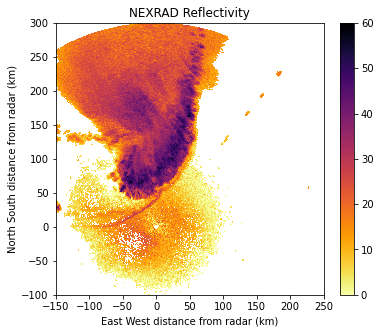

In [19]:
import matplotlib.pyplot as plt
display = pyart.graph.RadarDisplay(base)
fig = plt.figure(figsize=(6, 5))

# plot super resolution reflectivity
ax = fig.add_subplot(111)
display.plot('reflectivity', 0, title='NEXRAD Reflectivity',vmin=0,vmax=60,
              colorbar_label='', ax=ax,cmap='inferno_r',gatefilter=gatefilter)
display.plot_range_ring(base.range['data'][-1]/1000., ax=ax)
display.set_limits(xlim=(-150, 250), ylim=(-100, 300), ax=ax) #-200,150; -150,200
plt.show()

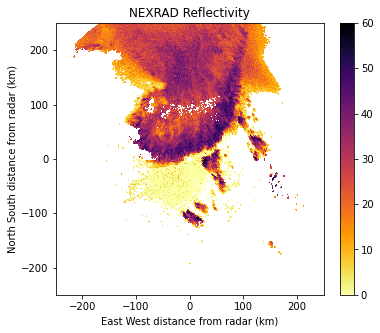

In [15]:
display = pyart.graph.RadarDisplay(base2)
fig = plt.figure(figsize=(6, 5))

# plot super resolution reflectivity
ax = fig.add_subplot(111)
display.plot('reflectivity', 0, title='NEXRAD Reflectivity',vmin=0,vmax=60,
              colorbar_label='', ax=ax,cmap='inferno_r',gatefilter=gatefilter)
display.plot_range_ring(base.range['data'][-1]/1000., ax=ax)
display.set_limits(xlim=(-250, 250), ylim=(-250, 250), ax=ax)
plt.show()

In [14]:
del gatefilter,gatefilter2
gatefilter = pyart.filters.GateFilter(base)
gatefilter.exclude_below('cross_correlation_ratio',0.7)
gatefilter2=pyart.filters.GateFilter(base2)
gatefilter2.exclude_below('cross_correlation_ratio', 0.7)

gatefilter.exclude_above('zdr_acorr', 6)
gatefilter.exclude_above('D0', 4.)
gatefilter = pyart.correct.despeckle.despeckle_field(base, 'D0', gatefilter=gatefilter)
gatefilter2.exclude_above('zdr_acorr', 6)
gatefilter2.exclude_above('D0', 4.)

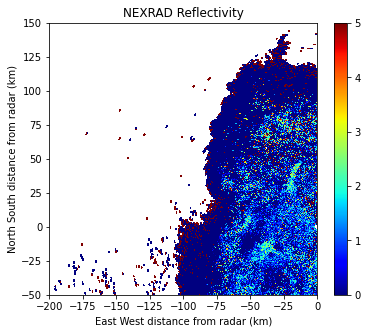

In [30]:
import matplotlib.pyplot as plt
display = pyart.graph.RadarDisplay(base)
fig = plt.figure(figsize=(6, 5))

# plot super resolution reflectivity
ax = fig.add_subplot(111)
display.plot('zdr_acorr', 0, title='NEXRAD Reflectivity',vmin=0,vmax=5,
              colorbar_label='', ax=ax,cmap='jet')#,gatefilter=gatefilter)
display.plot_range_ring(base.range['data'][-1]/1000., ax=ax)
display.set_limits(xlim=(-200, 0), ylim=(-50, 150), ax=ax)
plt.show()

In [15]:
(base.latitude['data'][0]+base2.latitude['data'][0])/2,(base.longitude['data'][0]+base2.longitude['data'][0])/2

(38.022743225097656, -93.83244705200195)

In [27]:
#grid
grid_shape  = (41, 351, 401)
grid_limits = ((0, 20000), (-175000.0, 175000.0), (-175000.0, 225000.0))
grid_roi    = 2000

###########################################################
# Gridded Processing and Output
###########################################################
out_fn  = '_'.join([base.metadata['instrument_name'],base2.metadata['instrument_name'],
                    dt.strftime('%Y%m%d_%H%M%S'),'grid_mass_comp']) + '.nc'
#out_ffn = ''.join([output_gridpath,out_fn])

#genreate grid object for cts fields
grid = pyart.map.grid_from_radars((base,base2),grid_shape = grid_shape,grid_limits = grid_limits,\
                                  grid_origin=(38.90359878540039, -95.2485122680664),gatefilters=(gatefilter, gatefilter2),\
                                  weighting_function = 'BARNES2',gridding_algo = 'map_gates_to_grid',roi_func='constant', constant_roi = grid_roi,\
                                  fields=['reflectivity', 'zdr_acorr', 'KDP','cross_correlation_ratio','MW','MI',\
                                          'D0','Nw','mu','rain_blend', 'ZDP','FI','temp_radiosonde','z_radiosonde','spectrum_width', 'SNR'])

In [16]:
import matplotlib.pyplot as plt
grid.z['data']

array([    0.,   500.,  1000.,  1500.,  2000.,  2500.,  3000.,  3500.,
        4000.,  4500.,  5000.,  5500.,  6000.,  6500.,  7000.,  7500.,
        8000.,  8500.,  9000.,  9500., 10000., 10500., 11000., 11500.,
       12000., 12500., 13000., 13500., 14000., 14500., 15000., 15500.,
       16000., 16500., 17000., 17500., 18000., 18500., 19000., 19500.,
       20000.])

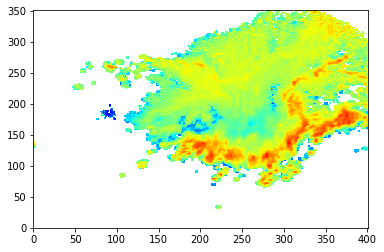

In [19]:
plt.pcolormesh(grid.fields['reflectivity']['data'][4,:,:],vmin=0,vmax=60,cmap='jet')
plt.show()

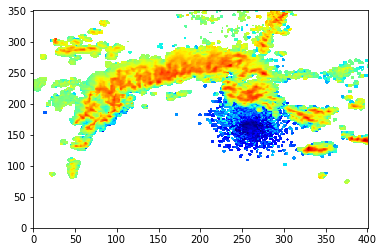

In [28]:
plt.pcolormesh(grid.fields['reflectivity']['data'][4,:,:],vmin=0,vmax=60,cmap='jet')
plt.show()

In [12]:
#grid
grid_shape  = (41, 301, 301)
grid_limits = ((0, 20000), (-150000.0, 150000.0), (-150000.0, 150000.0))
grid_roi    = 2000

###########################################################
# Gridded Processing and Output
###########################################################
out_fn  = '_'.join([base.metadata['instrument_name'], dt.strftime('%Y%m%d_%H%M%S'),'grid']) + '.nc'
out_ffn = ''.join([output_gridpath,out_fn])
    
#genreate grid object for cts fields
grid = pyart.map.grid_from_radars(base,grid_shape = grid_shape,grid_limits = grid_limits,gatefilters=gatefilter,
                                  weighting_function = 'Barnes',gridding_algo = 'map_gates_to_grid',
                                  roi_func='constant', constant_roi = grid_roi,
                                  fields=['reflectivity', 'zdr_acorr', 'KDP','cross_correlation_ratio',
                                          'D0','Nw','mu','rain_blend', 'ZDP',
                                          'FI','temp_radiosonde','z_radiosonde','spectrum_width', 'SNR'])

In [13]:
#generate grid object for discrete fields (using nearest neighbour)
import time
start_time = time.time()
    
grid_dis = pyart.map.grid_from_radars(base,grid_shape = grid_shape,grid_limits = grid_limits,
                                      gatefilters=gatefilter,weighting_function = 'Nearest',
                                      gridding_algo = 'map_to_grid',roi_func='constant', constant_roi = 1000,
                                      fields=['Thurai_class', 'PID'])    
    
print("--- %s seconds ---" % (time.time() - start_time))

--- 156.09131717681885 seconds ---


In [14]:
#add discrete gridded fields into master grid object
thurai_grid  = grid_dis.fields['Thurai_class']
pid_grid = grid_dis.fields['PID']
grid.add_field('Thurai_class', thurai_grid, replace_existing=True) 
grid.add_field('PID', pid_grid, replace_existing=True) 

In [15]:
# Unfold radial velocity
################################################################################
corrvel_kfsd = pyart.correct.dealias_region_based(base,vel_field='velocity')
#base.fields.pop('corrected_velocity')
base.add_field('corrected_velocity',corrvel_kfsd)
base.fields['corrected_velocity']['missing_value'] = 1.0 * base.fields['corrected_velocity']['_FillValue']

grid_vel = pyart.map.grid_from_radars(base,grid_shape = grid_shape,grid_limits = grid_limits,
                                  weighting_function = 'Barnes',gridding_algo = 'map_gates_to_grid',
                                  roi_func='constant', constant_roi = grid_roi,
                                  fields=['corrected_velocity'])
grid.add_field('corrected_velocity', grid_vel.fields['corrected_velocity'], replace_existing=True)

/scra6/ft21894/anaconda3/envs/cdat/lib/python3.7/site-packages/pyart/correct/region_dealias.py:309: UserWarning: Velocities outside of the Nyquist interval found in sweep 1.
  warnings.warn(msg, UserWarning)
/scra6/ft21894/anaconda3/envs/cdat/lib/python3.7/site-packages/pyart/correct/region_dealias.py:309: UserWarning: Velocities outside of the Nyquist interval found in sweep 3.
  warnings.warn(msg, UserWarning)
/scra6/ft21894/anaconda3/envs/cdat/lib/python3.7/site-packages/pyart/correct/region_dealias.py:309: UserWarning: Velocities outside of the Nyquist interval found in sweep 5.
  warnings.warn(msg, UserWarning)
/scra6/ft21894/anaconda3/envs/cdat/lib/python3.7/site-packages/pyart/correct/region_dealias.py:309: UserWarning: Velocities outside of the Nyquist interval found in sweep 6.
  warnings.warn(msg, UserWarning)
/scra6/ft21894/anaconda3/envs/cdat/lib/python3.7/site-packages/pyart/correct/region_dealias.py:309: UserWarning: Velocities outside of the Nyquist interval found in swe

In [16]:
pyart.io.write_grid(out_ffn, grid, format='NETCDF4', write_proj_coord_sys=True,
                    proj_coord_sys=None, arm_time_variables=False, arm_alt_lat_lon_variables=True, 
                    write_point_x_y_z=True, write_point_lon_lat_alt=True)

In [17]:
from csu_radartools import csu_liquid_ice_mass

In [18]:
dz = tools.extract_unmasked_data(base,'reflectivity')
dr = tools.extract_unmasked_data(base,'zdr_acorr')
mw, mi = csu_liquid_ice_mass.calc_liquid_ice_mass(dz, dr, z0620/1000.0, T=T0620)
#radar = add_field_to_radar_object(mw, radar, field_name='MW', units='g m-3',
#                                  long_name='Liquid Water Mass',
#                                  standard_name='Liquid Water Mass')
#radar = add_field_to_radar_object(mi, radar, field_name='MI', units='g m-3',long_name='Ice Water Mass',
#                                  standard_name='Ice Water Mass')


In [20]:
base = tools.add_field_to_radar_object(mw, base, 'MW', 'g m-3',
                                  'Liquid Water Mass','Liquid Water Mass','reflectivity')
base = tools.add_field_to_radar_object(mi, base, 'MI', 'g m-3','Ice Water Mass','Ice Water Mass','reflectivity')

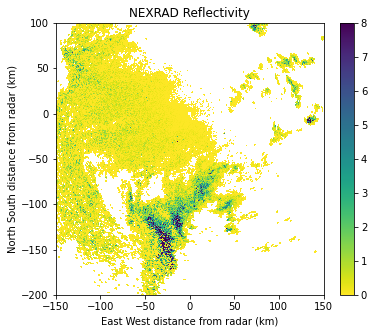

In [21]:
fig = plt.figure(figsize=(6, 5))

# plot super resolution reflectivity
ax = fig.add_subplot(111)
display.plot('MW', 0, title='NEXRAD Reflectivity',vmin=0,vmax=8,
              colorbar_label='', ax=ax,cmap='viridis_r',gatefilter=gatefilter)
display.plot_range_ring(base.range['data'][-1]/1000., ax=ax)
display.set_limits(xlim=(-150, 150), ylim=(-200, 100), ax=ax)
plt.show()